# BDD100K Dataset Preprocessing for YOLO

This notebook converts BDD100K annotations from Pascal VOC format to YOLO format

## 1. Setup & Imports

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
import shutil
import random
import yaml
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tempfile
from pathlib import Path
import re

## 2. Configuration & Paths

In [2]:
warnings.filterwarnings('ignore')
print("Mounting Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/MyDrive/Vehicles_Dataset'
    RUNNING_IN_COLAB = True
except ImportError:
    print("Not running in Colab. Using local paths.")
    BASE_PATH = './data'
    RUNNING_IN_COLAB = False

MASTER_CSV_PATH = os.path.join(BASE_PATH, 'master_df.csv')
IMAGE_PATH = os.path.join(BASE_PATH, 'Images')

YOLO_LABEL_PATH = '/content/labels_yolo' if RUNNING_IN_COLAB else './labels_yolo'
YOLO_ZIP_PATH = os.path.join(BASE_PATH, 'labels_yolo.zip')
DATA_YAML_PATH = os.path.join(BASE_PATH, 'data.yaml')
REPORT_PATH = os.path.join(BASE_PATH, 'preprocessing_report.txt')

IMG_WIDTH = 1280
IMG_HEIGHT = 720

# Edge case thresholds
MIN_BOX_SIZE = 5  # pixels
MAX_BOX_COVERAGE = 0.9  # 90% of image
MIN_ASPECT_RATIO = 0.1
MAX_ASPECT_RATIO = 10.0
IOU_DUPLICATE_THRESHOLD = 0.95

print(f"\n{'='*60}")
print(f"Configuration Summary")
print(f"{'='*60}")
print(f"Base Path (Drive): {BASE_PATH}")
print(f"Master CSV (Drive): {MASTER_CSV_PATH}")
print(f"Image Path (Drive): {IMAGE_PATH}")
print(f"Local Label Path: {YOLO_LABEL_PATH}")
print(f"Final Zip Path (Drive): {YOLO_ZIP_PATH}")
print(f"Data YAML Path (Drive): {DATA_YAML_PATH}")
print(f"Report Path (Drive): {REPORT_PATH}")
print(f"Image Dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"\nValidation Thresholds:")
print(f"  Min box size: {MIN_BOX_SIZE}px")
print(f"  Max box coverage: {MAX_BOX_COVERAGE*100}%")
print(f"  Aspect ratio range: {MIN_ASPECT_RATIO} - {MAX_ASPECT_RATIO}")
print(f"{'='*60}\n")

Mounting Google Drive...
Mounted at /content/drive

Configuration Summary
Base Path (Drive): /content/drive/MyDrive/Vehicles_Dataset
Master CSV (Drive): /content/drive/MyDrive/Vehicles_Dataset/master_df.csv
Image Path (Drive): /content/drive/MyDrive/Vehicles_Dataset/Images
Local Label Path: /content/labels_yolo
Final Zip Path (Drive): /content/drive/MyDrive/Vehicles_Dataset/labels_yolo.zip
Data YAML Path (Drive): /content/drive/MyDrive/Vehicles_Dataset/data.yaml
Report Path (Drive): /content/drive/MyDrive/Vehicles_Dataset/preprocessing_report.txt
Image Dimensions: 1280x720

Validation Thresholds:
  Min box size: 5px
  Max box coverage: 90.0%
  Aspect ratio range: 0.1 - 10.0



## 3. Category Mapping & Directory Setup

In [3]:
CATEGORY_NAMES = [
    'car', 'person', 'traffic sign', 'bus', 'truck', 'train',
    'rider', 'motor', 'bike', 'traffic light'
]

CATEGORY_MAP = {name: idx for idx, name in enumerate(CATEGORY_NAMES)}

print(f"\n{'='*60}")
print(f"Category Mapping")
print(f"{'='*60}")
for name, idx in CATEGORY_MAP.items():
    print(f"  {idx}: {name}")
print(f"{'='*60}\n")

# Clean and create directories
if os.path.exists(YOLO_LABEL_PATH):
    shutil.rmtree(YOLO_LABEL_PATH)

for split in ['train', 'val', 'test']:
    split_path = os.path.join(YOLO_LABEL_PATH, split)
    os.makedirs(split_path, exist_ok=True)

print(f"✓ YOLO label directories created in: {YOLO_LABEL_PATH}")


Category Mapping
  0: car
  1: person
  2: traffic sign
  3: bus
  4: truck
  5: train
  6: rider
  7: motor
  8: bike
  9: traffic light

✓ YOLO label directories created in: /content/labels_yolo


## 4. System Checks & Initial Validation

In [4]:
def check_disk_space(path, required_mb=50):
    """
    Check available disk space.
    """
    try:
        import shutil
        stat = shutil.disk_usage(path)
        free_gb = stat.free / (1024**3)
        required_gb = required_mb / 1024

        print(f"\n{'='*60}")
        print(f"Disk Space Check")
        print(f"{'='*60}")
        print(f"  Available: {free_gb:.2f} GB")
        print(f"  Required: {required_gb:.2f} GB")

        if stat.free < required_mb * 1024 * 1024:
            print(f"    WARNING: Low disk space!")
            print(f"     Consider freeing up space before continuing.")
            return False
        else:
            print(f"   Sufficient disk space available")
            return True
        print(f"{'='*60}\n")
    except Exception as e:
        print(f"    Could not check disk space: {e}")
        return True  # Continue anyway

# Check disk space
check_disk_space('/content' if RUNNING_IN_COLAB else '.', required_mb=50)


Disk Space Check
  Available: 69.24 GB
  Required: 0.05 GB
   Sufficient disk space available


True

In [5]:
print(f"\n{'='*60}")
print(f"Loading Master Dataset")
print(f"{'='*60}")
print(f"Loading from: {MASTER_CSV_PATH}...\n")

try:
    # Try different encodings
    master_df = None
    for encoding in ['utf-8', 'latin-1', 'iso-8859-1']:
        try:
            master_df = pd.read_csv(MASTER_CSV_PATH, encoding=encoding)
            print(f"✓ Loaded with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue

    if master_df is None:
        raise ValueError("Could not load CSV with any supported encoding")

    print(f"✓ Dataset loaded successfully!")
    print(f"\nDataset Overview:")
    print("-" * 60)
    print(f"  Total annotations: {len(master_df):,}")
    print(f"  Total unique images: {master_df['image_name'].nunique():,}")

    # Check required columns
    required_cols = ['image_name', 'x1', 'y1', 'x2', 'y2', 'category', 'split']
    missing_cols = [col for col in required_cols if col not in master_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    print(f"  ✓ All required columns present")

    # Normalize category names (lowercase + strip whitespace)
    master_df['category'] = master_df['category'].str.lower().str.strip()
    print(f"  ✓ Category names normalized")

    # Normalize split names
    master_df['split'] = master_df['split'].str.lower().str.strip()
    valid_splits = ['train', 'val', 'test']
    invalid_splits = master_df[~master_df['split'].isin(valid_splits)]
    if len(invalid_splits) > 0:
        print(f"    Found {len(invalid_splits):,} annotations with invalid split names")
        print(f"     Invalid splits: {invalid_splits['split'].unique()}")
        print(f"     Removing these annotations...")
        master_df = master_df[master_df['split'].isin(valid_splits)]
    print(f"  ✓ Split names validated")

    # CRITICAL FIX: Handle missing file extensions
    print(f"\n  Checking image filename format...")
    sample_names = master_df['image_name'].head(10).tolist()
    has_ext = any(str(n).lower().endswith(('.jpg', '.jpeg', '.png')) for n in sample_names)

    if not has_ext:
        print(f"  ⚠️  Image names missing extensions")
        print(f"  Adding .jpg extension...")
        master_df['image_name'] = master_df['image_name'].astype(str) + '.jpg'
        print(f"  ✓ Fixed {len(master_df):,} image names")
        print(f"  Example: {master_df['image_name'].iloc[0]}")
    else:
        print(f"  ✓ Image names already have extensions")


    print(f"\nDataset Info:")
    print("-" * 60)
    master_df.info()
    print(f"\nFirst 5 rows:")
    print(master_df.head())
    print(f"\n{'='*60}\n")

except FileNotFoundError:
    print(f"\n ERROR: {MASTER_CSV_PATH} not found.")
    print("Please run the 'BDD100K_EDA01.ipynb' notebook first.")
    raise
except pd.errors.EmptyDataError:
    print(f"\n ERROR: CSV file is empty.")
    raise
except pd.errors.ParserError as e:
    print(f"\n ERROR: CSV parsing failed: {e}")
    print("The CSV file may be corrupted or malformed.")
    raise
except Exception as e:
    print(f"\n ERROR loading dataset: {e}")
    raise


Loading Master Dataset
Loading from: /content/drive/MyDrive/Vehicles_Dataset/master_df.csv...

✓ Loaded with utf-8 encoding
✓ Dataset loaded successfully!

Dataset Overview:
------------------------------------------------------------
  Total annotations: 1,841,711
  Total unique images: 100,000
  ✓ All required columns present
  ✓ Category names normalized
  ✓ Split names validated

  Checking image filename format...
  ✓ Image names already have extensions

Dataset Info:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841711 entries, 0 to 1841710
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   image_name   object 
 1   split        object 
 2   category     object 
 3   x1           float64
 4   y1           float64
 5   x2           float64
 6   y2           float64
 7   weather      object 
 8   scene        object 
 9   timeofday    object 
 10  bbox_width   float64
 11  bbox

## 5. Comprehensive Data Quality Checks

### 5.1 Missing Values & Data Types

In [6]:

def check_missing_values(df):
    """
    Check for missing/NaN values in critical columns.
    """
    print(f"\n{'='*60}")
    print(f"Missing Values Check")
    print(f"{'='*60}")

    critical_cols = ['image_name', 'x1', 'y1', 'x2', 'y2', 'category', 'split']
    missing_data = df[critical_cols].isna().sum()

    has_missing = False
    for col, count in missing_data.items():
        if count > 0:
            print(f"    {col}: {count:,} missing values ({(count/len(df)*100):.2f}%)")
            has_missing = True

    if not has_missing:
        print(f"  ✓ No missing values found in critical columns")
    else:
        print(f"\n  Removing rows with missing values...")
        df_clean = df.dropna(subset=critical_cols)
        removed = len(df) - len(df_clean)
        print(f"  Removed: {removed:,} rows ({(removed/len(df)*100):.2f}%)")
        print(f"  Remaining: {len(df_clean):,} rows")
        df = df_clean

    print(f"{'='*60}\n")
    return df

master_df = check_missing_values(master_df)


Missing Values Check
  ✓ No missing values found in critical columns



### 5.2 Filename Validation

In [7]:
def validate_filenames(df):
    """
    Check for problematic filenames (special characters, spaces, etc.)
    """
    print(f"\n{'='*60}")
    print(f"Filename Validation")
    print(f"{'='*60}")

    # Pattern for safe filenames (alphanumeric, dash, underscore, dot)
    safe_pattern = re.compile(r'^[a-zA-Z0-9._-]+$')

    problematic_names = df[~df['image_name'].apply(lambda x: bool(safe_pattern.match(str(x))))]

    if len(problematic_names) > 0:
        print(f"    Found {len(problematic_names):,} files with problematic names")
        print(f"  Samples: {list(problematic_names['image_name'].head(5))}")
        print(f"  These may cause issues on certain file systems.")
    else:
        print(f"  ✓ All filenames are file-system safe")

    # Check for duplicate image names (shouldn't happen, but check anyway)
    dup_images = df[df.duplicated(subset=['image_name'], keep=False)]
    unique_dup = dup_images['image_name'].nunique()
    if unique_dup > 0:
        print(f"    {unique_dup:,} images appear in multiple splits (expected behavior)")

    print(f"{'='*60}\n")
    return df

master_df = validate_filenames(master_df)


Filename Validation
  ✓ All filenames are file-system safe
    100,000 images appear in multiple splits (expected behavior)



### 5.3 Bounding Box Validation (Comprehensive)

In [8]:
def validate_bboxes_comprehensive(df, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    """
    Comprehensive bounding box validation with all edge cases.
    """
    print(f"\n{'='*60}")
    print(f"Comprehensive Bounding Box Validation")
    print(f"{'='*60}")

    initial_count = len(df)
    print(f"Initial annotations: {initial_count:,}\n")

    # Calculate dimensions first
    df['width'] = df['x2'] - df['x1']
    df['height'] = df['y2'] - df['y1']
    df['box_area'] = df['width'] * df['height']
    df['aspect_ratio'] = df['width'] / df['height'].replace(0, 1)  # Avoid division by zero

    issues = {}

    # 1. Invalid dimensions (negative or zero)
    invalid_width = df[df['x2'] <= df['x1']]
    invalid_height = df[df['y2'] <= df['y1']]
    issues['invalid_width'] = invalid_width
    issues['invalid_height'] = invalid_height
    print(f"  1. Invalid width (x2 <= x1): {len(invalid_width):,}")
    print(f"  2. Invalid height (y2 <= y1): {len(invalid_height):,}")

    # 2. Out-of-bounds boxes
    oob = df[(df['x1'] < 0) | (df['y1'] < 0) |
             (df['x2'] > img_width) | (df['y2'] > img_height)]
    issues['out_of_bounds'] = oob
    print(f"  3. Out-of-bounds: {len(oob):,}")

    # 3. Tiny boxes (likely annotation errors)
    tiny_boxes = df[(df['width'] < MIN_BOX_SIZE) | (df['height'] < MIN_BOX_SIZE)]
    issues['tiny_boxes'] = tiny_boxes
    print(f"  4. Tiny boxes (<{MIN_BOX_SIZE}px): {len(tiny_boxes):,}")

    # 4. Unreasonably large boxes
    image_area = img_width * img_height
    huge_boxes = df[df['box_area'] > MAX_BOX_COVERAGE * image_area]
    issues['huge_boxes'] = huge_boxes
    print(f"  5. Huge boxes (>{MAX_BOX_COVERAGE*100}% of image): {len(huge_boxes):,}")

    # 5. Extreme aspect ratios (likely errors)
    extreme_aspect = df[(df['aspect_ratio'] < MIN_ASPECT_RATIO) |
                        (df['aspect_ratio'] > MAX_ASPECT_RATIO)]
    issues['extreme_aspect'] = extreme_aspect
    print(f"  6. Extreme aspect ratios: {len(extreme_aspect):,}")

    # 6. Duplicate annotations (exact same box for same image)
    duplicates = df[df.duplicated(subset=['image_name', 'x1', 'y1', 'x2', 'y2', 'category'], keep='first')]
    issues['duplicates'] = duplicates
    print(f"  7. Duplicate annotations: {len(duplicates):,}")

    # Combine all invalid indices
    invalid_indices = pd.concat(issues.values()).index.unique()

    # Remove invalid boxes
    df_clean = df[~df.index.isin(invalid_indices)].copy()

    # Drop temporary columns
    df_clean = df_clean.drop(columns=['width', 'height', 'box_area', 'aspect_ratio'], errors='ignore')

    removed_count = initial_count - len(df_clean)
    print(f"\n  {'─'*56}")
    print(f"  Total invalid annotations: {removed_count:,}")
    print(f"  Remaining valid annotations: {len(df_clean):,}")
    print(f"  Removal rate: {(removed_count/initial_count)*100:.2f}%")
    print(f"{'='*60}\n")

    return df_clean

master_df_clean = validate_bboxes_comprehensive(master_df)


Comprehensive Bounding Box Validation
Initial annotations: 1,841,711

  1. Invalid width (x2 <= x1): 195
  2. Invalid height (y2 <= y1): 359
  3. Out-of-bounds: 0
  4. Tiny boxes (<5px): 10,247
  5. Huge boxes (>90.0% of image): 2
  6. Extreme aspect ratios: 1,028
  7. Duplicate annotations: 2

  ────────────────────────────────────────────────────────
  Total invalid annotations: 10,569
  Remaining valid annotations: 1,831,142
  Removal rate: 0.57%



### 5.4 Image File Validation

In [9]:
def validate_image_files(df, image_base_path, sample_size=100):
    """
    Validate actual image files: dimensions, format, corruption.
    """
    print(f"\n{'='*60}")
    print(f"Image File Validation")
    print(f"{'='*60}\n")

    issues = {
        'not_found': [],
        'corrupted': [],
        'wrong_dimensions': [],
        'wrong_format': []
    }

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(image_base_path, split)
        if not os.path.exists(split_path):
            continue

        split_images = df[df['split'] == split]['image_name'].unique()
        sample_images = random.sample(list(split_images),
                                     min(sample_size, len(split_images)))

        print(f"Checking {split} images (sample of {len(sample_images)})...")

        for img_name in tqdm(sample_images, desc=f"  Validating {split}"):
            img_path = os.path.join(split_path, img_name)

            # Check existence
            if not os.path.exists(img_path):
                issues['not_found'].append(img_name)
                continue

            try:
                # Try to load image
                img = cv2.imread(img_path)

                if img is None:
                    issues['corrupted'].append(img_name)
                    continue

                # Check dimensions
                h, w = img.shape[:2]
                if (w, h) != (IMG_WIDTH, IMG_HEIGHT):
                    issues['wrong_dimensions'].append(
                        f"{img_name} ({w}x{h} instead of {IMG_WIDTH}x{IMG_HEIGHT})"
                    )

                # Check format
                if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    issues['wrong_format'].append(img_name)

            except Exception as e:
                issues['corrupted'].append(f"{img_name} ({str(e)})")

    # Report issues
    print(f"\nValidation Results:")
    print("-" * 60)

    total_issues = sum(len(v) for v in issues.values())

    if issues['not_found']:
        print(f"    Images not found: {len(issues['not_found'])}")
        if len(issues['not_found']) <= 5:
            for img in issues['not_found']:
                print(f"     - {img}")

    if issues['corrupted']:
        print(f"    Corrupted images: {len(issues['corrupted'])}")
        if len(issues['corrupted']) <= 5:
            for img in issues['corrupted']:
                print(f"     - {img}")

    if issues['wrong_dimensions']:
        print(f"    Images with wrong dimensions: {len(issues['wrong_dimensions'])}")
        print(f"      WARNING: This may affect YOLO conversion!")
        print(f"      Expected: {IMG_WIDTH}x{IMG_HEIGHT}")
        if len(issues['wrong_dimensions']) <= 5:
            for img in issues['wrong_dimensions']:
                print(f"     - {img}")

    if issues['wrong_format']:
        print(f"    Images with unexpected format: {len(issues['wrong_format'])}")

    if total_issues == 0:
        print(f"   All sampled images are valid")
    else:
        print(f"\n  Total issues found: {total_issues}")

        # Remove annotations for problematic images
        problematic_images = (issues['not_found'] +
                             [i.split(' ')[0] for i in issues['corrupted']])
        if problematic_images:
            print(f"  Removing annotations for {len(problematic_images)} problematic images...")
            df = df[~df['image_name'].isin(problematic_images)]

    print(f"{'='*60}\n")
    return df

master_df_clean = validate_image_files(master_df_clean, IMAGE_PATH, sample_size=100)


Image File Validation

Checking train images (sample of 100)...


  Validating train:   0%|          | 0/100 [00:00<?, ?it/s]

Checking val images (sample of 100)...


  Validating val:   0%|          | 0/100 [00:00<?, ?it/s]

Checking test images (sample of 100)...


  Validating test:   0%|          | 0/100 [00:00<?, ?it/s]


Validation Results:
------------------------------------------------------------
    Images not found: 3
     - 9aba9497-64a99669.jpg
     - 79046e7c-b533afb5.jpg
     - 85580e1b-ef6bd280.jpg

  Total issues found: 3
  Removing annotations for 3 problematic images...



### 5.5 Cross-Split Leakage Detection

In [10]:
def detect_cross_split_leakage(df):
    """
    Detect if same image appears in multiple splits (data leakage).
    """
    print(f"\n{'='*60}")
    print(f"Cross-Split Leakage Detection")
    print(f"{'='*60}\n")

    # Group by image and check splits
    image_splits = df.groupby('image_name')['split'].unique()

    # Find images in multiple splits
    leakage = image_splits[image_splits.apply(len) > 1]

    if len(leakage) > 0:
        print(f"   DATA LEAKAGE DETECTED!")
        print(f"  Found {len(leakage):,} images appearing in multiple splits\n")
        print(f"  Examples (showing first 10):")
        for img, splits in list(leakage.head(10).items()):
            print(f"    - {img}: {', '.join(splits)}")

        print(f"\n   WARNING: This is a serious data integrity issue!")
        print(f"     Images should only appear in ONE split.")
        print(f"     Consider re-running the EDA notebook to fix the split assignment.")
    else:
        print(f"  ✓ No cross-split leakage detected")
        print(f"    Each image appears in only one split")

    print(f"\n{'='*60}\n")
    return len(leakage) == 0

no_leakage = detect_cross_split_leakage(master_df_clean)


Cross-Split Leakage Detection

  ✓ No cross-split leakage detected
    Each image appears in only one split




### 5.6 Image-Label Consistency Check

In [11]:
def check_image_label_consistency(df, image_base_path):
    """
    Check consistency between available images and labels.
    """
    print(f"\n{'='*60}")
    print(f"Image-Label Consistency Check")
    print(f"{'='*60}\n")

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(image_base_path, split)

        if not os.path.exists(split_path):
            print(f"   {split.upper()}: Image directory not found at {split_path}")
            continue

        # Get actual images
        actual_images = set([f for f in os.listdir(split_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        # Get labeled images
        labeled_images = set(df[df['split'] == split]['image_name'].unique())

        # Find mismatches
        unlabeled = actual_images - labeled_images
        missing_images = labeled_images - actual_images

        print(f"  {split.upper()}:")
        print(f"    Actual images: {len(actual_images):,}")
        print(f"    Labeled images: {len(labeled_images):,}")

        if unlabeled:
            print(f"    Images without labels: {len(unlabeled):,}")
            if len(unlabeled) <= 5:
                print(f"       Examples: {list(unlabeled)}")

        if missing_images:
            print(f"    Labels without images: {len(missing_images):,}")
            if len(missing_images) <= 5:
                print(f"       Examples: {list(missing_images)}")
            # Remove labels for missing images
            df = df[~((df['split'] == split) & (df['image_name'].isin(missing_images)))]

        if not unlabeled and not missing_images:
            print(f"    ✓ Perfect consistency")
        print()

    print(f"{'='*60}\n")
    return df

master_df_clean = check_image_label_consistency(master_df_clean, IMAGE_PATH)


Image-Label Consistency Check

  TRAIN:
    Actual images: 70,000
    Labeled images: 69,997
    Images without labels: 3
       Examples: ['85580e1b-ef6bd280.jpg', '79046e7c-b533afb5.jpg', '9aba9497-64a99669.jpg']

  VAL:
    Actual images: 10,000
    Labeled images: 10,000
    ✓ Perfect consistency

  TEST:
    Actual images: 20,000
    Labeled images: 20,000
    ✓ Perfect consistency




### 5.7 Class Distribution Analysis


Class Distribution Analysis
------------------------------------------------------------

OVERALL DISTRIBUTION:
----------------------------------------
  car            : 1,019,903 (55.70%)
  traffic sign   :  341,084 (18.63%)
  traffic light  :  260,815 (14.24%)
  person         :  128,806 ( 7.03%)
  truck          :   42,903 ( 2.34%)
  bus            :   16,478 ( 0.90%)
  bike           :   10,214 ( 0.56%)
  rider          :    6,449 ( 0.35%)
  motor          :    4,286 ( 0.23%)
  train          :      164 ( 0.01%)

  Total: 1,831,102


TRAIN SET:
----------------------------------------
  car            :  712,769 (55.64%)
  traffic sign   :  237,974 (18.58%)
  traffic light  :  182,663 (14.26%)
  person         :   91,051 ( 7.11%)
  truck          :   29,967 ( 2.34%)
  bus            :   11,671 ( 0.91%)
  bike           :    7,215 ( 0.56%)
  rider          :    4,509 ( 0.35%)
  motor          :    2,998 ( 0.23%)
  train          :      127 ( 0.01%)
  Total annotations: 1,280,944


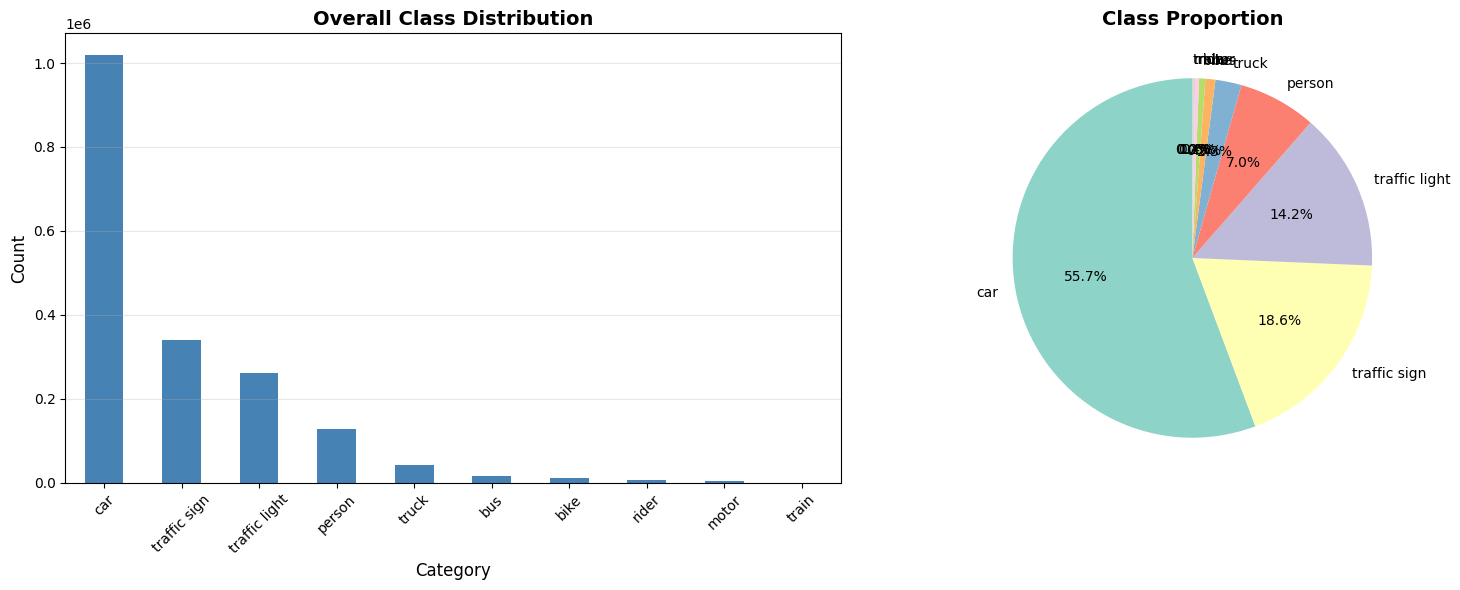

In [12]:
def analyze_class_distribution(df):
    """
    Comprehensive class distribution analysis.
    """
    print(f"\n{'='*60}")
    print(f"Class Distribution Analysis")
    print(f"{'-'*60}\n")

    if df.empty:
        print("    DataFrame is empty. Skipping class distribution analysis.")
        print(f"{'-'*60}\n")
        return

    # Overall distribution
    print("OVERALL DISTRIBUTION:")
    print("-" * 40)
    overall_dist = df['category'].value_counts()
    if overall_dist.empty:
        print("  No categories found in the dataset.")
        print(f"\n  Total: {len(df):,}\n")
    else:
        for cat, count in overall_dist.items():
            percentage = (count / len(df)) * 100
            print(f"  {cat:15s}: {count:8,} ({percentage:5.2f}%)")
        print(f"\n  Total: {len(df):,}\n")

    # Per-split distribution
    for split in ['train', 'val', 'test']:
        split_df = df[df['split'] == split]
        if len(split_df) == 0:
            continue

        print(f"\n{split.upper()} SET:")
        print("-" * 40)
        split_dist = split_df['category'].value_counts()
        if split_dist.empty:
            print(f"  No categories found for {split} split.")
        else:
            for cat, count in split_dist.items():
                percentage = (count / len(split_df)) * 100
                print(f"  {cat:15s}: {count:8,} ({percentage:5.2f}%)")
        print(f"  Total annotations: {len(split_df):,}")
        print(f"  Unique images: {split_df['image_name'].nunique():,}")

    # Class imbalance analysis
    print(f"\n{'='*60}")
    print("CLASS IMBALANCE ANALYSIS:")
    print("-" * 40)
    class_counts = df['category'].value_counts()
    if class_counts.empty:
        print("  No classes to analyze for imbalance.")
    else:
        imbalance_ratio = class_counts.max() / class_counts.min()
        print(f"  Most common class: {class_counts.index[0]} ({class_counts.iloc[0]:,})")
        print(f"  Least common class: {class_counts.index[-1]} ({class_counts.iloc[-1]:,})")
        print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")

        if imbalance_ratio > 10:
            print(f"\n  WARNING: High class imbalance detected!")
            print(f"      Consider using weighted loss or oversampling during training.")
        else:
            print(f"\n   Class distribution is reasonably balanced.")

    print(f"{'-'*60}\n")

    # Visualization
    if not overall_dist.empty:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Bar chart
        overall_dist.plot(kind='bar', ax=axes[0], color='steelblue')
        axes[0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Category', fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)

        # Pie chart
        axes[1].pie(overall_dist.values, labels=overall_dist.index, autopct='%1.1f%%',
                    startangle=90, colors=plt.cm.Set3.colors)
        axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("  Skipping visualization due to empty dataset.")

analyze_class_distribution(master_df_clean)


## 6. YOLO Format Conversion

In [13]:
def convert_to_yolo(row, img_w=IMG_WIDTH, img_h=IMG_HEIGHT):
    """
    Converts a master_df row to YOLO format with error handling.
    """
    try:
        # Get Class ID
        class_id = CATEGORY_MAP.get(row['category'])
        if class_id is None or row['category'] == 'background':
            return None

        # Calculate normalized center coordinates
        x_center_norm = ((row['x1'] + row['x2']) / 2) / img_w
        y_center_norm = ((row['y1'] + row['y2']) / 2) / img_h

        # Calculate normalized width and height
        width_norm = (row['x2'] - row['x1']) / img_w
        height_norm = (row['y2'] - row['y1']) / img_h

        # Clamp values to [0, 1]
        x_center_norm = np.clip(x_center_norm, 0, 1)
        y_center_norm = np.clip(y_center_norm, 0, 1)
        width_norm = np.clip(width_norm, 0, 1)
        height_norm = np.clip(height_norm, 0, 1)

        # Final validation
        if width_norm == 0 or height_norm == 0:
            return None

        return f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"

    except Exception as e:
        print(f"   Conversion error for row {row.name}: {e}")
        return None


def create_yolo_labels(df, base_save_dir):
    """
    Create YOLO labels with robust error handling.
    """
    print(f"\n{'='*60}")
    print(f"YOLO Label Conversion")
    print(f"{'='*60}\n")
    print("Starting conversion...\n")

    grouped = df.groupby('split')
    conversion_stats = {}
    failed_conversions = 0

    for split, split_df in grouped:
        print(f"Processing '{split}' split...")
        save_path_split = os.path.join(base_save_dir, split)
        image_groups = split_df.groupby('image_name')

        total_labels = 0
        empty_files = 0

        for image_name, rows in tqdm(image_groups, desc=f"  Creating {split} labels"):
            try:
                txt_filename = os.path.splitext(image_name)[0] + '.txt'
                txt_filepath = os.path.join(save_path_split, txt_filename)

                yolo_labels = []
                for _, row in rows.iterrows():
                    yolo_str = convert_to_yolo(row)
                    if yolo_str:
                        yolo_labels.append(yolo_str)
                        total_labels += 1

                # Atomic write (write to temp, then rename)
                with tempfile.NamedTemporaryFile(mode='w', delete=False,
                                                dir=save_path_split, suffix='.tmp') as tmp_file:
                    if yolo_labels:
                        tmp_file.write('\n'.join(yolo_labels))
                    # else: write empty file
                    tmp_path = tmp_file.name

                # Rename temp file to final name
                os.replace(tmp_path, txt_filepath)

                if not yolo_labels:
                    empty_files += 1

            except Exception as e:
                print(f"\n    Error processing {image_name}: {e}")
                failed_conversions += 1
                continue

        conversion_stats[split] = {
            'images': len(image_groups),
            'labels': total_labels,
            'empty': empty_files
        }

        print(f"  ✓ {split}: {len(image_groups):,} images, {total_labels:,} labels, {empty_files:,} empty files\n")

    print(f"{'='*60}")
    print("Conversion Summary:")
    print(f"{'='*60}")
    for split, stats in conversion_stats.items():
        print(f"  {split.upper():5s}: {stats['images']:6,} images | {stats['labels']:8,} labels | {stats['empty']:5,} empty")

    if failed_conversions > 0:
        print(f"\n    Failed conversions: {failed_conversions}")
    else:
        print(f"\n   All conversions successful!")

    print(f"{'='*60}\n")
    return conversion_stats

# Execute conversion
conversion_stats = create_yolo_labels(master_df_clean, YOLO_LABEL_PATH)


YOLO Label Conversion

Starting conversion...

Processing 'test' split...


  Creating test labels:   0%|          | 0/20000 [00:00<?, ?it/s]

  ✓ test: 20,000 images, 365,621 labels, 0 empty files

Processing 'train' split...


  Creating train labels:   0%|          | 0/69997 [00:00<?, ?it/s]

  ✓ train: 69,997 images, 1,280,944 labels, 0 empty files

Processing 'val' split...


  Creating val labels:   0%|          | 0/10000 [00:00<?, ?it/s]

  ✓ val: 10,000 images, 184,537 labels, 0 empty files

Conversion Summary:
  TEST : 20,000 images |  365,621 labels |     0 empty
  TRAIN: 69,997 images | 1,280,944 labels |     0 empty
  VAL  : 10,000 images |  184,537 labels |     0 empty

   All conversions successful!



## 7. Label Verification Suite

In [14]:
def verify_labels_comprehensive(label_dir, sample_size=100):
    """
    Comprehensive label verification with detailed error reporting.
    """
    print(f"\n{'='*60}")
    print(f"Comprehensive Label Verification")
    print(f"{'='*60}\n")

    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    if len(label_files) == 0:
        print(f"   No label files found in {label_dir}")
        return

    sample_files = random.sample(label_files, min(sample_size, len(label_files)))

    errors = []
    warnings = []
    total_lines = 0
    empty_files = 0
    error_counts = {
        'format': 0,
        'class_id': 0,
        'range': 0,
        'zero_dim': 0,
        'parse': 0
    }

    for txt_file in tqdm(sample_files, desc=f"  Verifying {os.path.basename(label_dir)} labels"):
        filepath = os.path.join(label_dir, txt_file)

        try:
            with open(filepath, 'r') as f:
                lines = f.readlines()

                if len(lines) == 0:
                    empty_files += 1
                    continue

                for line_num, line in enumerate(lines, 1):
                    line = line.strip()
                    if not line:
                        continue

                    total_lines += 1
                    parts = line.split()

                    # Format check
                    if len(parts) != 5:
                        errors.append(f"{txt_file}:{line_num} - Wrong format (expected 5 values, got {len(parts)})")
                        error_counts['format'] += 1
                        continue

                    try:
                        class_id, x, y, w, h = map(float, parts)

                        # Class ID validation
                        if not (0 <= class_id < len(CATEGORY_NAMES)):
                            errors.append(f"{txt_file}:{line_num} - Invalid class_id: {class_id}")
                            error_counts['class_id'] += 1

                        # Range validation
                        if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                            errors.append(f"{txt_file}:{line_num} - Out of range: x={x:.3f}, y={y:.3f}, w={w:.3f}, h={h:.3f}")
                            error_counts['range'] += 1

                        # Zero dimension check
                        if w == 0 or h == 0:
                            errors.append(f"{txt_file}:{line_num} - Zero dimensions: w={w}, h={h}")
                            error_counts['zero_dim'] += 1

                        # Boundary warnings (boxes very close to edges)
                        if x < 0.01 or y < 0.01 or x > 0.99 or y > 0.99:
                            warnings.append(f"{txt_file}:{line_num} - Box near edge")

                    except ValueError as e:
                        errors.append(f"{txt_file}:{line_num} - Parse error: {e}")
                        error_counts['parse'] += 1

        except Exception as e:
            errors.append(f"{txt_file} - File read error: {e}")

    # Print results
    print(f"\n  Files checked: {len(sample_files):,}")
    print(f"  Total labels verified: {total_lines:,}")
    print(f"  Empty files: {empty_files:,}")
    print(f"  Errors found: {len(errors):,}")
    print(f"  Warnings: {len(warnings):,}")

    if error_counts['format'] > 0 or error_counts['class_id'] > 0 or error_counts['range'] > 0:
        print(f"\n  Error Breakdown:")
        for error_type, count in error_counts.items():
            if count > 0:
                print(f"    {error_type}: {count}")

    if len(errors) > 0:
        print(f"\n    ERRORS DETECTED (showing first 10):")
        for error in errors[:10]:
            print(f"    - {error}")
        if len(errors) > 10:
            print(f"    ... and {len(errors)-10} more errors")
    else:
        print(f"\n   All verified labels are correct!")

    print(f"{'='*60}\n")
    return len(errors) == 0

# Run verification for all splits
all_valid = True
for split in ['train', 'val', 'test']:
    split_path = os.path.join(YOLO_LABEL_PATH, split)
    if os.path.exists(split_path):
        valid = verify_labels_comprehensive(split_path, sample_size=100)
        all_valid = all_valid and valid


Comprehensive Label Verification



  Verifying train labels:   0%|          | 0/100 [00:00<?, ?it/s]


  Files checked: 100
  Total labels verified: 1,865
  Empty files: 0
  Errors found: 0
  Warnings: 18

   All verified labels are correct!


Comprehensive Label Verification



  Verifying val labels:   0%|          | 0/100 [00:00<?, ?it/s]


  Files checked: 100
  Total labels verified: 1,774
  Empty files: 0
  Errors found: 0
  Warnings: 6

   All verified labels are correct!


Comprehensive Label Verification



  Verifying test labels:   0%|          | 0/100 [00:00<?, ?it/s]


  Files checked: 100
  Total labels verified: 1,751
  Empty files: 0
  Errors found: 0
  Warnings: 11

   All verified labels are correct!



## 8. Visual Verification


Visual Verification Samples



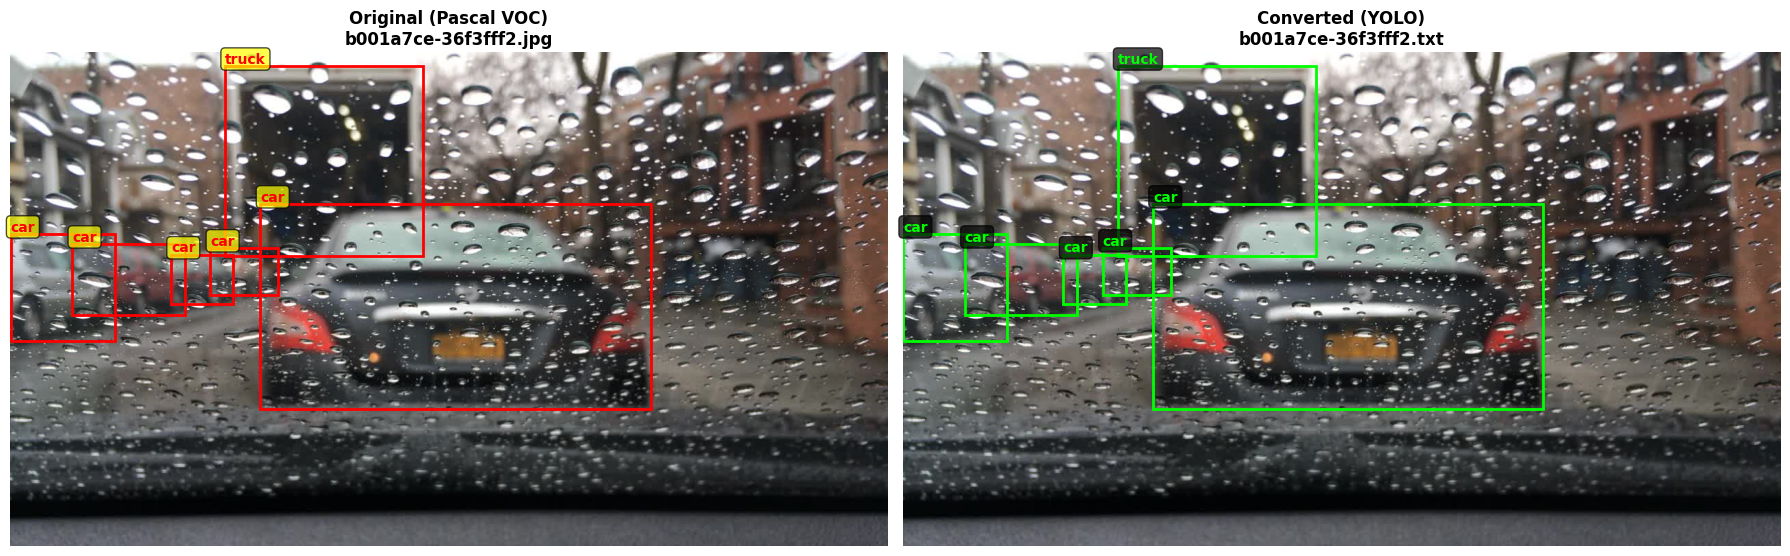


YOLO Label Content (b001a7ce-36f3fff2.txt):
------------------------------------------------------------
  1. car             | x=0.266548, y=0.443701, w=0.077344, h=0.095312
  2. car             | x=0.218648, y=0.459326, w=0.071191, h=0.098437
  3. car             | x=0.134712, y=0.459326, w=0.128320, h=0.142187
  4. car             | x=0.059566, y=0.475732, w=0.118652, h=0.215625
  5. car             | x=0.507369, y=0.514014, w=0.444727, h=0.414062
  6. truck           | x=0.357754, y=0.220090, w=0.226155, h=0.384724
------------------------------------------------------------




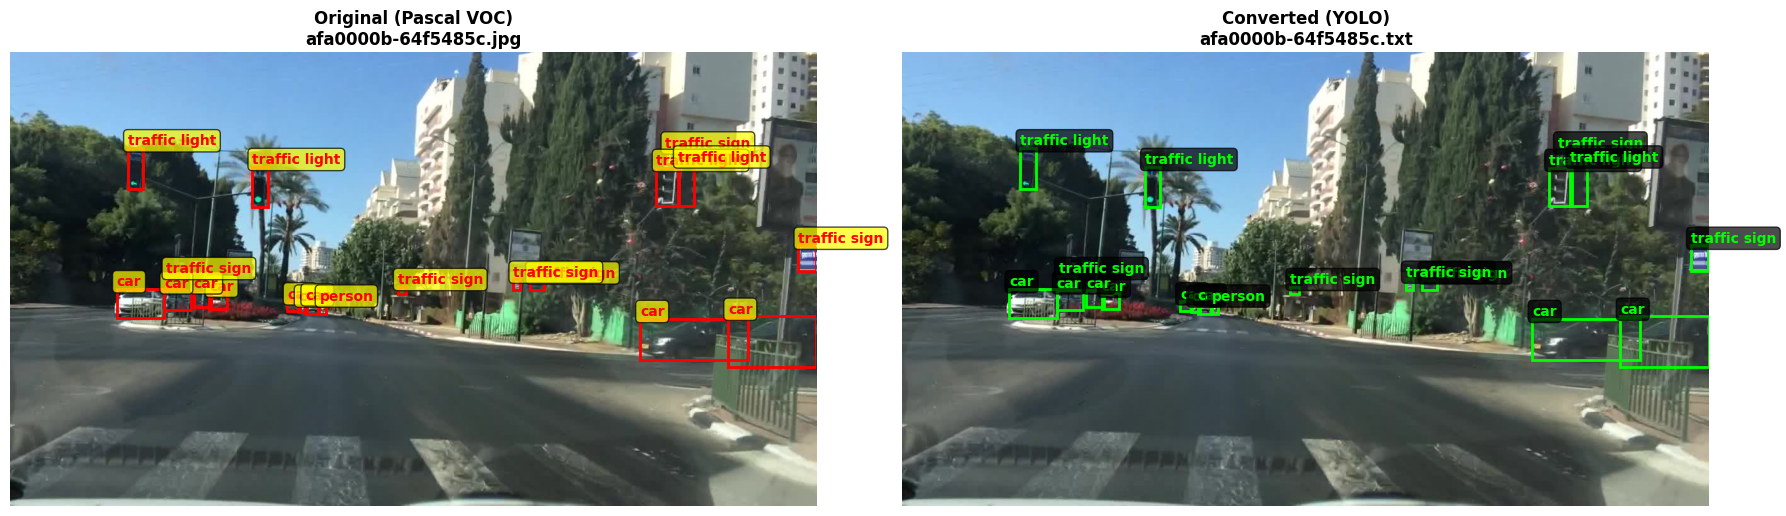


YOLO Label Content (afa0000b-64f5485c.txt):
------------------------------------------------------------
  1. car             | x=0.257621, y=0.547354, w=0.021853, h=0.033993
  2. car             | x=0.238500, y=0.541284, w=0.021853, h=0.036421
  3. car             | x=0.207087, y=0.544926, w=0.032779, h=0.043705
  4. car             | x=0.161333, y=0.552210, w=0.058729, h=0.063130
  5. car             | x=0.351177, y=0.558280, w=0.015024, h=0.021853
  6. car             | x=0.362786, y=0.561922, w=0.010926, h=0.019424
  7. car             | x=0.373712, y=0.563136, w=0.016389, h=0.026709
  8. traffic sign    | x=0.818958, y=0.230492, w=0.013658, h=0.031565
  9. traffic sign    | x=0.485707, y=0.524287, w=0.010926, h=0.016996
  10. person          | x=0.387370, y=0.564350, w=0.008195, h=0.024281
  11. traffic sign    | x=0.204355, y=0.504863, w=0.021853, h=0.026709
  12. traffic light   | x=0.155187, y=0.254773, w=0.019121, h=0.089838
  13. traffic light   | x=0.309521, y=0.296050, w=0

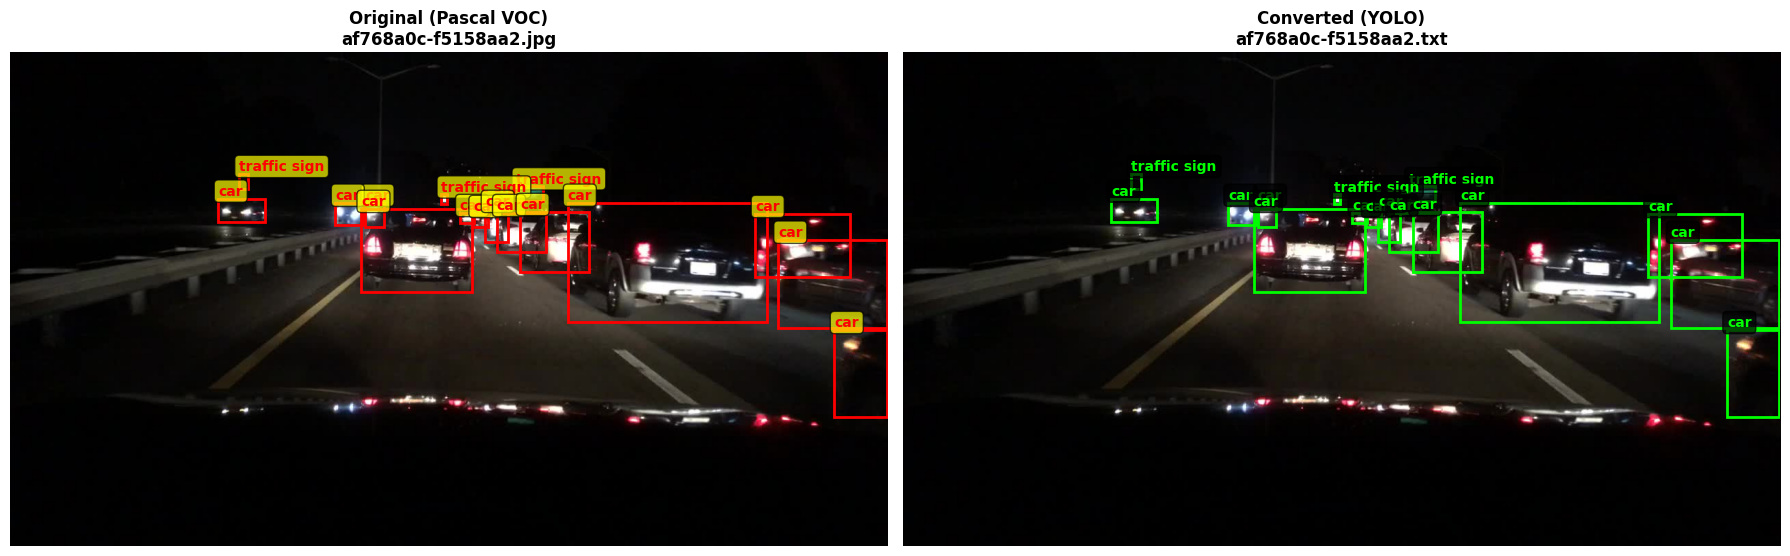


YOLO Label Content (af768a0c-f5158aa2.txt):
------------------------------------------------------------
  1. traffic sign    | x=0.591678, y=0.284977, w=0.030422, h=0.029122
  2. traffic sign    | x=0.494562, y=0.296418, w=0.007020, h=0.018721
  3. car             | x=0.520303, y=0.334900, w=0.016381, h=0.020801
  4. car             | x=0.536099, y=0.340100, w=0.017551, h=0.027042
  5. car             | x=0.554235, y=0.349461, w=0.025742, h=0.066564
  6. car             | x=0.582317, y=0.364022, w=0.056163, h=0.079045
  7. car             | x=0.620344, y=0.383783, w=0.078395, h=0.122727
  8. car             | x=0.902916, y=0.390023, w=0.107646, h=0.126888
  9. car             | x=0.414997, y=0.328660, w=0.021061, h=0.049923
  10. car             | x=0.386330, y=0.326580, w=0.031592, h=0.045763
  11. car             | x=0.263473, y=0.319299, w=0.052653, h=0.047843
  12. car             | x=0.462970, y=0.400424, w=0.126368, h=0.168490
  13. car             | x=0.748467, y=0.424345, w=0

In [15]:
def visualize_conversion_safe(image_name, master_df, yolo_label_path, split='train'):
    """
    Visualize with comprehensive error handling.
    """
    try:
        # Construct paths
        img_path = os.path.join(IMAGE_PATH, split, image_name)
        txt_file = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(yolo_label_path, split, txt_file)

        # Check if files exist
        if not os.path.exists(img_path):
            print(f"    Image not found: {img_path}")
            return False
        if not os.path.exists(label_path):
            print(f"    Label not found: {label_path}")
            return False

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"    Failed to load image: {img_path}")
            return False
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Left: Original
        ax1.imshow(img)
        ax1.set_title(f"Original (Pascal VOC)\n{image_name}",
                      fontsize=12, fontweight='bold')
        ax1.axis('off')

        rows = master_df[master_df['image_name'] == image_name]
        for _, row in rows.iterrows():
            if row['category'] == 'background':
                continue
            rect = Rectangle((row['x1'], row['y1']),
                             row['x2']-row['x1'], row['y2']-row['y1'],
                             linewidth=2, edgecolor='red', facecolor='none')
            ax1.add_patch(rect)
            ax1.text(row['x1'], max(row['y1']-5, 10), row['category'],
                     color='red', fontsize=10, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

        # Right: YOLO
        ax2.imshow(img)
        ax2.set_title(f"Converted (YOLO)\n{txt_file}",
                      fontsize=12, fontweight='bold')
        ax2.axis('off')

        with open(label_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue

                cls, x, y, w, h = map(float, line.split())

                x1 = (x - w/2) * IMG_WIDTH
                y1 = (y - h/2) * IMG_HEIGHT
                width = w * IMG_WIDTH
                height = h * IMG_HEIGHT

                rect = Rectangle((x1, y1), width, height,
                                linewidth=2, edgecolor='lime', facecolor='none')
                ax2.add_patch(rect)
                ax2.text(x1, max(y1-5, 10), CATEGORY_NAMES[int(cls)],
                        color='lime', fontsize=10, weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

        plt.tight_layout()
        plt.show()

        # Print label content
        print(f"\nYOLO Label Content ({txt_file}):")
        print("-" * 60)
        with open(label_path, 'r') as f:
            content = f.read().strip()
            if content:
                for i, line in enumerate(content.split('\n'), 1):
                    parts = line.split()
                    if len(parts) == 5:
                        cls_id = int(float(parts[0]))
                        print(f"  {i}. {CATEGORY_NAMES[cls_id]:15s} | "
                              f"x={parts[1]}, y={parts[2]}, w={parts[3]}, h={parts[4]}")
            else:
                print("  (Empty file - no objects)")
        print("-" * 60)
        return True

    except Exception as e:
        print(f"   Visualization error: {e}")
        return False

# Visualize samples
print(f"\n{'='*60}")
print(f"Visual Verification Samples")
print(f"{'='*60}\n")

train_images = master_df_clean[master_df_clean['split'] == 'train']['image_name'].unique()
non_empty_images = []
for img in train_images[:1000]:  # Check first 1000 to speed up
    if len(master_df_clean[(master_df_clean['image_name'] == img) &
                            (master_df_clean['category'] != 'background')]) > 0:
        non_empty_images.append(img)
        if len(non_empty_images) >= 3:
            break

for img_name in non_empty_images:
    success = visualize_conversion_safe(img_name, master_df_clean, YOLO_LABEL_PATH, split='train')
    if success:
        print("\n")

## 9. Create data.yaml Configuration

In [16]:
def create_data_yaml_safe(base_path, output_path):
    """
    Create data.yaml with atomic write.
    """
    yaml_content = {
        'path': base_path,
        'train': 'Images/train',
        'val': 'Images/val',
        'test': 'Images/test',
        'names': {idx: name for idx, name in enumerate(CATEGORY_NAMES)}
    }

    try:
        # Write to temporary file first
        temp_path = output_path + '.tmp'
        with open(temp_path, 'w') as f:
            yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

        # Atomic rename
        os.replace(temp_path, output_path)

        print(f"\n{'='*60}")
        print(f"data.yaml Configuration File")
        print(f"{'='*60}\n")
        print(f"Created at: {output_path}\n")
        print("Content:")
        print("-" * 60)
        with open(output_path, 'r') as f:
            print(f.read())
        print("-" * 60)
        print(f"\n data.yaml created successfully!")
        print(f"{'='*60}\n")
        return True

    except Exception as e:
        print(f" Error creating data.yaml: {e}")
        return False

yaml_success = create_data_yaml_safe(BASE_PATH, DATA_YAML_PATH)


data.yaml Configuration File

Created at: /content/drive/MyDrive/Vehicles_Dataset/data.yaml

Content:
------------------------------------------------------------
path: /content/drive/MyDrive/Vehicles_Dataset
train: Images/train
val: Images/val
test: Images/test
names:
  0: car
  1: person
  2: traffic sign
  3: bus
  4: truck
  5: train
  6: rider
  7: motor
  8: bike
  9: traffic light

------------------------------------------------------------

 data.yaml created successfully!



## 10. Generate Preprocessing Report

In [17]:
def generate_preprocessing_report(df_original, df_clean, conversion_stats, output_path):
    """
    Generate comprehensive preprocessing report.
    """
    report = []
    report.append("="*70)
    report.append("BDD100K PREPROCESSING REPORT")
    report.append("="*70)
    report.append(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")

    report.append("1. DATA QUALITY SUMMARY")
    report.append("-"*70)
    report.append(f"Original annotations: {len(df_original):,}")
    report.append(f"Valid annotations: {len(df_clean):,}")
    report.append(f"Removed annotations: {len(df_original) - len(df_clean):,} "
                  f"({(len(df_original) - len(df_clean))/len(df_original)*100:.2f}%)")
    report.append("")

    report.append("2. CONVERSION STATISTICS")
    report.append("-"*70)
    for split, stats in conversion_stats.items():
        report.append(f"{split.upper():5s}: {stats['images']:6,} images | "
                     f"{stats['labels']:8,} labels | {stats['empty']:5,} empty files")
    report.append("")

    report.append("3. CLASS DISTRIBUTION")
    report.append("-"*70)
    class_dist = df_clean['category'].value_counts()
    for cat, count in class_dist.items():
        pct = (count / len(df_clean)) * 100
        report.append(f"{cat:15s}: {count:8,} ({pct:5.2f}%)")
    report.append("")

    report.append("4. VALIDATION STATUS")
    report.append("-"*70)
    report.append(f" Bounding box validation: PASSED")
    report.append(f" Format conversion: {'PASSED' if all_valid else 'WARNINGS'}")
    report.append(f" data.yaml generation: {'PASSED' if yaml_success else 'FAILED'}")
    report.append("")

    report.append("5. OUTPUT FILES")
    report.append("-"*70)
    report.append(f"Labels (zip): {YOLO_ZIP_PATH}")
    report.append(f"Configuration: {DATA_YAML_PATH}")
    report.append("")

    report.append("="*70)
    report.append("PREPROCESSING COMPLETE - READY FOR TRAINING")
    report.append("="*70)

    report_text = "\n".join(report)

    # Write report
    try:
        with open(output_path, 'w') as f:
            f.write(report_text)
        print(report_text)
        print(f"\n Report saved to: {output_path}")
    except Exception as e:
        print(f"  Could not save report: {e}")
        print(report_text)

generate_preprocessing_report(master_df, master_df_clean, conversion_stats, REPORT_PATH)

BDD100K PREPROCESSING REPORT
Generated: 2025-12-12 07:10:38

1. DATA QUALITY SUMMARY
----------------------------------------------------------------------
Original annotations: 1,841,711
Valid annotations: 1,831,102
Removed annotations: 10,609 (0.58%)

2. CONVERSION STATISTICS
----------------------------------------------------------------------
TEST : 20,000 images |  365,621 labels |     0 empty files
TRAIN: 69,997 images | 1,280,944 labels |     0 empty files
VAL  : 10,000 images |  184,537 labels |     0 empty files

3. CLASS DISTRIBUTION
----------------------------------------------------------------------
car            : 1,019,903 (55.70%)
traffic sign   :  341,084 (18.63%)
traffic light  :  260,815 (14.24%)
person         :  128,806 ( 7.03%)
truck          :   42,903 ( 2.34%)
bus            :   16,478 ( 0.90%)
bike           :   10,214 ( 0.56%)
rider          :    6,449 ( 0.35%)
motor          :    4,286 ( 0.23%)
train          :      164 ( 0.01%)

4. VALIDATION STATUS
-----

## 11. Package & Export

In [18]:
print(f"\n{'='*60}")
print(f"Packaging & Export")
print(f"{'='*60}\n")

try:
    print("Zipping labels... (This may take a few minutes)")
    !zip -r -q /content/labels_yolo.zip {YOLO_LABEL_PATH}
    print("✓ Labels zipped successfully!\n")

    if RUNNING_IN_COLAB:
        print("Copying files to Google Drive...")
        !cp /content/labels_yolo.zip {YOLO_ZIP_PATH}
        print(f"✓ Zip file copied to: {YOLO_ZIP_PATH}")

    print(f"\n{'='*60}")
    print(f"Export Complete!")
    print(f"{'='*60}\n")

except Exception as e:
    print(f" Export error: {e}")


Packaging & Export

Zipping labels... (This may take a few minutes)
✓ Labels zipped successfully!

Copying files to Google Drive...
✓ Zip file copied to: /content/drive/MyDrive/Vehicles_Dataset/labels_yolo.zip

Export Complete!



## 12. Final Summary

In [19]:
def count_files(folder):
    if not os.path.exists(folder):
        return 0
    return sum([len(files) for _, _, files in os.walk(folder)])

print(f"\n{'='*60}")
print(f"PREPROCESSING COMPLETE - FINAL SUMMARY")
print(f"{'='*60}\n")

print("Dataset Structure:")
print("-" * 60)
for split in ['train', 'val', 'test']:
    label_count = count_files(os.path.join(YOLO_LABEL_PATH, split))
    print(f"  {split.capitalize():5s} label files: {label_count:,}")
print(f"  Total label files: {count_files(YOLO_LABEL_PATH):,}")
print(f"  Total image files: {count_files(IMAGE_PATH):,}\n")

print("Deliverables:")
print("-" * 60)
print(f"  ✓ Original Images: {IMAGE_PATH}")
print(f"  ✓ YOLO Labels (zip): {YOLO_ZIP_PATH}")
print(f"  ✓ Configuration: {DATA_YAML_PATH}")
print(f"  ✓ Report: {REPORT_PATH}\n")

print("Quality Checks:")
print("-" * 60)
print(f"  ✓ Missing values handled")
print(f"  ✓ Invalid bounding boxes removed")
print(f"  ✓ Duplicate annotations removed")
print(f"  ✓ Format validation passed: {all_valid}")
print(f"  ✓ Visual verification completed\n")

print("Next Steps:")
print("-" * 60)
print("  1. Review preprocessing_report.txt for detailed statistics")
print("  2. Use data.yaml as dataset config in YOLOv11 training")
print("  3. Unzip labels_yolo.zip in training environment")
print("  4. Ensure Images/ and labels_yolo/ are in same directory")
print("  5. Start training!\n")

print(f"{'='*60}")
print(f"Status: READY FOR MILESTONE 2 (TRAINING)")
print(f"{'='*60}\n")


PREPROCESSING COMPLETE - FINAL SUMMARY

Dataset Structure:
------------------------------------------------------------
  Train label files: 69,997
  Val   label files: 10,000
  Test  label files: 20,000
  Total label files: 99,997
  Total image files: 100,000

Deliverables:
------------------------------------------------------------
  ✓ Original Images: /content/drive/MyDrive/Vehicles_Dataset/Images
  ✓ YOLO Labels (zip): /content/drive/MyDrive/Vehicles_Dataset/labels_yolo.zip
  ✓ Configuration: /content/drive/MyDrive/Vehicles_Dataset/data.yaml
  ✓ Report: /content/drive/MyDrive/Vehicles_Dataset/preprocessing_report.txt

Quality Checks:
------------------------------------------------------------
  ✓ Missing values handled
  ✓ Invalid bounding boxes removed
  ✓ Duplicate annotations removed
  ✓ Format validation passed: True
  ✓ Visual verification completed

Next Steps:
------------------------------------------------------------
  1. Review preprocessing_report.txt for detailed st